# phageParser - Analysis of CRISPR Type for Locus Sizes

C.K. Yildirim (cemyildirim@fastmail.com)

The latest version of this [IPython notebook](http://ipython.org/notebook.html) demo is available at [http://github.com/phageParser/phageParser](https://github.com/phageParser/phageParser/tree/django-dev/demos)

## Introduction

This demo uses the REST API of phageParser running locally to plot the distribution of spacer lengths.
In this case, the API is consumed using the requests library and the json responses are parsed for gathering
basepair length information of spacers.

In [1]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
sns.set_palette("husl")

In [2]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']

In [3]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

In [4]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

In [5]:
#Make a set of specific cas proteins by grouping them from gene field
cas3_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas3' in v['gene']}
cas9_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas9' in v['gene']}
cas10_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas10' in v['gene']}

In [6]:
#Estimate the CRISPR type in organisms by checking the identified cas proteins in each organism
#Also find the locus size by checking if all of the loci in an organism consist of a single spacer
for k,v in organism_dict.items():
    v['CRISPR_type'] = []
    v['single_spacer'] = False
    if v['cas_proteins']:
        org_proteins = set(v['cas_proteins'])
        if not org_proteins.isdisjoint(cas3_proteins): #has cas3 proteins
            v['CRISPR_type'] += ['Type I']
        if not org_proteins.isdisjoint(cas9_proteins): #has cas9 proteins
            v['CRISPR_type'] += ['Type II']
        if not org_proteins.isdisjoint(cas10_proteins): #has cas10 proteins
            v['CRISPR_type'] += ['Type III']
    if v['loci']:
        if all([len(loc['spacers']) < 2 for loc in v['loci']]):
            v['single_spacer'] = True

In [7]:
#Calculate the availability of an active CRISPR system for each organism, group by single or multiple spacers.
iscrispr_single_spacer = [bool(v['CRISPR_type']) for k,v in organism_dict.items() if v['single_spacer']]
iscrispr_multi_spacer = [bool(v['CRISPR_type']) for k,v in organism_dict.items() if not v['single_spacer']]
iscrispr_single_spacer_prc = sum(iscrispr_single_spacer)/len(iscrispr_single_spacer)*100
iscrispr_multi_spacer_prc = sum(iscrispr_multi_spacer)/len(iscrispr_multi_spacer)*100
print("Active CRISPR system percentage for organisms with single spacer is {:.2f}%".format(iscrispr_single_spacer_prc))
print("Active CRISPR system percentage for organisms with multiple spacer is {:.2f}%".format(iscrispr_multi_spacer_prc))

Active CRISPR system percentage for organisms with single spacer is 97.46%
Active CRISPR system percentage for organisms with multiple spacer is 97.32%


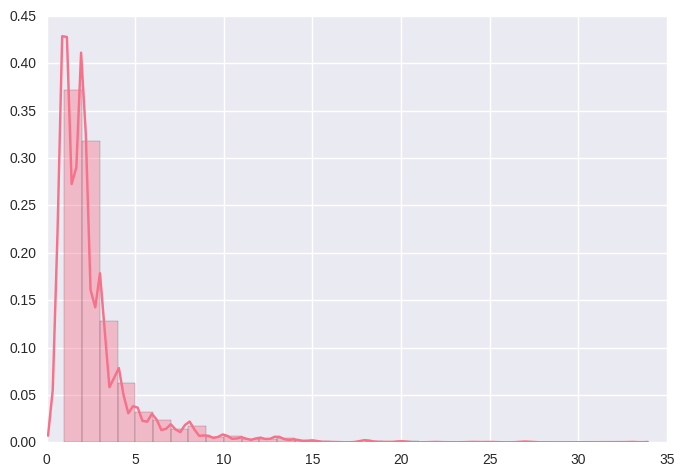

2.604001176816711

In [9]:
num_loc = [len(v['loci']) for k,v in organism_dict.items() if v['loci']]
sns.distplot(num_loc, bins=range(0,30,1))
plt.show()
sum(num_loc)/len(num_loc)


In [10]:
#Get the global mean and variance
spacerbplengths = np.array([spacer['length'] for organism in organism_dict.values() for locus in organism['loci'] for spacer in locus['spacers']]).flatten()
mu, sigma = spacerbplengths.mean(), spacerbplengths.std()
print("Calculated mean basepair length for spacers is {:.2f}+/-{:.2f}".format(mu,sigma))

Calculated mean basepair length for spacers is 35.10+/-3.93


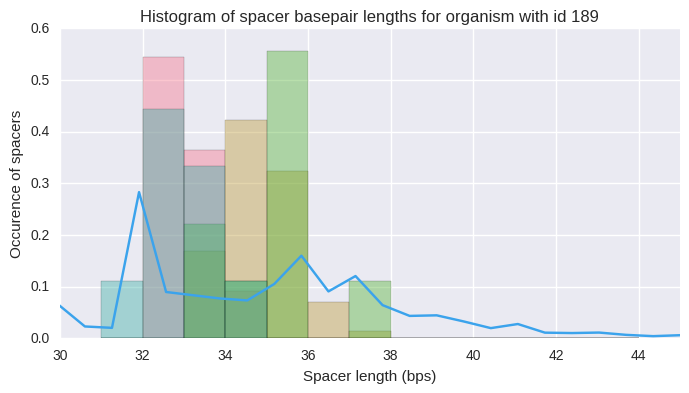

In [11]:
#Pick a random organism to plot the histogram with global distribution overlay
# org_id = random.choice(list(org_spacer.keys()))
org_id=189
locusspacerlens = [[spacer['length'] for spacer in locus['spacers']] for locus in organism_dict[org_id]['loci']]
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
bins=range(30,45,1)
#Plot histogram of spacer length frequency
for loc in locusspacerlens:
    sns.distplot(loc, ax=ax, kde=False, norm_hist=True, bins=bins)
sns.kdeplot(spacerbplengths, ax=ax)
plt.xlim([30,45])

#format the figure and label
ax.set_title("Histogram of spacer basepair lengths for organism with id {}".format(org_id))
ax.set_xlabel("Spacer length (bps)")
ax.set_ylabel("Occurence of spacers")
plt.show()